<img src="https://www.inf.utfsm.cl/images/slides/Departamento-de-Informtica_HORIZONTAL.png" title="Title text" width="80%" />

<hr style="height:2px;border:none"/>
<h1 align='center'> INF-398/578 Introducción al aprendizaje automático</h1>

<h4 align='center'><b>Tarea 2: Árboles y SVM.</b></h4>


<h6 align='center'><b>Profesor:</b> Carlos Valle</h6>
<h6 align='center'><b>Ayudante:</b> Jean Aravena</h6>



<hr style="height:2px;border:none"/>

# **Tarea 2 📃**

## **Temas**  

* Árboles y SVM para regresión.
* Árboles y SVM para clasificación.
* Explainability.


## **Formalidades** 

* Equipos de trabajo de 2 personas.
* El entregable debe ser este mismo Jupyter Notebook incluyendo todos los resultados, los gráficos realizados y las respuestas a las preguntas. 
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el Jupyter Notebook que entregarán.
* Formato de entrega: Subir a aula el Jupyter Notebook con el nombre NombreGrupo_Tarea_2_ML_2022_1
* Fecha de entrega y presentaciones: 10 de Junio. Hora límite de entrega: 14:00.
 

<hr style="height:2px;border:none"/>

La tarea se divide en 2 partes:

1.   Árboles y SVM.
2.   Desafío.


La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo, solo son guías y pueden ser creativos al momento de resolver la tarea. También en algunas ocasiones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.

Recuerden intercalar su código con comentarios y utilizar celdas Markdown en caso de que sea necesario para realizar análisis, escribir fórmulas o realizar explicaciones que les parezca relevante para justificar sus procedimientos. 

Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará mucho la elección en sí, en cambio la argumentación detrás de la elección será lo más ponderado.

*Se recomienda el uso de Google Colab para realizar la tarea.*

# Librerias 📚
 

In [ ]:
!pip install -q lime
!pip install -q shap

In [ ]:
# No estan todas las librerias necesarias
# Agregue las que requiera para la tarea

import os
import re
import lime
import shap
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


sns.set_theme()
warnings.filterwarnings('ignore')

# Utils ⚙️  

In [ ]:
print("Mounting your Google Drive ...")

from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

# Path to your folder
path = '/content/drive/MyDrive/Machine Learning/Data'

Mounting your Google Drive ...
Mounted at /content/drive


In [ ]:
# Set all seed.
def set_all_seed(seed=0):
  """Set the same seed for all the libraries that we use."""
  np.random.seed(seed)

# Elegir cualquier semilla y siempre que se pueda utilizarla
# random_state = SEED
SEED = 2022

set_all_seed(seed=SEED)

# 1.1) Árboles y SVM para regresión 📈 

<img src="https://drive.google.com/uc?id=1ptvwiiJ8rz0KfV25bl53MTmw1OACn90h" width="50%"/>

Para la primera parte de la tarea trabajaremos con el dataset [Seoul Bike Sharing Demand](https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand) el cual viene del repositorio público [UCI](https://archive.ics.uci.edu/ml/index.php).

La data corresponde a 8.760 instancias las cuales tienen relación con la cantidad de bicicletas arrendadas en Seoul para el periodo entre diciembre de 2017 y noviembre de 2018. Ademas contiene información que puede ser relevante para la predicción como lo son los datos meteorológicos y los datos de los feriados o vacaciones para ese periodo de tiempo.


Para el dataset se tienen 13 features :

* `Date`: Día/Mes/Año
* `Hour`: Hora
* `Temperature`: Temperatura [°C]
* `Humidity`: Humedad
* `Wind speed`: Velocidad del viento [m/s]
* `Visibility`: Visibilidad considerando 10 metros de distancia
* `Dew point temperature`: Temperatura de rocío [°C]
* `Solar Radiation`: Radiación solar [MJ/m2]
* `Rainfall`: Lluvia [mm]
* `Snowfall`: Nieve [cm]
* `Seasons`: Estación del año
* `Holiday`: Si es feriado o no / vacaciones
* `Functioning Day`: Si es una hora funcional o no

y un target:

* `Rented Bike Count`: Cantidad de bicicletas arrendadas


## Carga de datos

Lo primero que vamos a hacer es cargar la data y explorar un poco su contenido

In [ ]:
# Cargar la data que corresponde a un csv
PATH_TO_CSV = os.path.join(path, "tarea_2_seoul_bike.csv")
df_data = pd.read_csv(PATH_TO_CSV, encoding='cp1252')

In [ ]:
df_data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
# Solo por temas de comodidad vamos a estandarizar el nombre de las columnas
def standarize_column_mame(column_name):
  column_name = re.sub("\([^)]*\)", "", column_name)
  column_name = "_".join(column_name.lower().rstrip().split(" "))
  return column_name

new_column_names = {name: standarize_column_mame(name) for name in df_data.columns}

df_data.rename(columns=new_column_names, inplace=True)

In [ ]:
df_data.head()

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Exploración de la data

**Genere estadísticas simples para conocer un poco la data y si encuentra algo que no corresponda decida qué hacer con ello**. Comente el resultado [1 Pts]

In [ ]:
### START CODE HERE ###

# Mostrar el numero de ejemplos que tenemos
print(f"Number of examples: {len(df_data)}")

# Mostrar las dimensiones de la data
print(f"Shape of the data: {df_data.shape}")
print("-------------")
# Mostrar los tipos de dato de cada columna
print(f"Data Types: {df_data.dtypes}")
print("-------------")
df_data.describe()

Number of examples: 8760
Shape of the data: (8760, 14)
-------------
Data Types: date                      object
rented_bike_count          int64
hour                       int64
temperature              float64
humidity                   int64
wind_speed               float64
visibility                 int64
dew_point_temperature    float64
solar_radiation          float64
rainfall                 float64
snowfall                 float64
seasons                   object
holiday                   object
functioning_day           object
dtype: object
-------------


,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


In [ ]:
# Contar la cantidad de null en las columnas (si hubieran muchos habria que buscar alguna forma de lidear con ello). 
df_data.isna().sum()

date                     0
rented_bike_count        0
hour                     0
temperature              0
humidity                 0
wind_speed               0
visibility               0
dew_point_temperature    0
solar_radiation          0
rainfall                 0
snowfall                 0
seasons                  0
holiday                  0
functioning_day          0
dtype: int64

**Genere gráficos individuales y/o de pares para explorar más la data**. Comente lo que observa de cada gráfico [2 Pts]

Para esta parte, transformaremos el atributo date para que sea el index del dataframe. De esta manera, asociamos automaticamente a su evolución en el tiempo en los gráficos.

In [ ]:
df_data_wi = df_data.set_index('date')

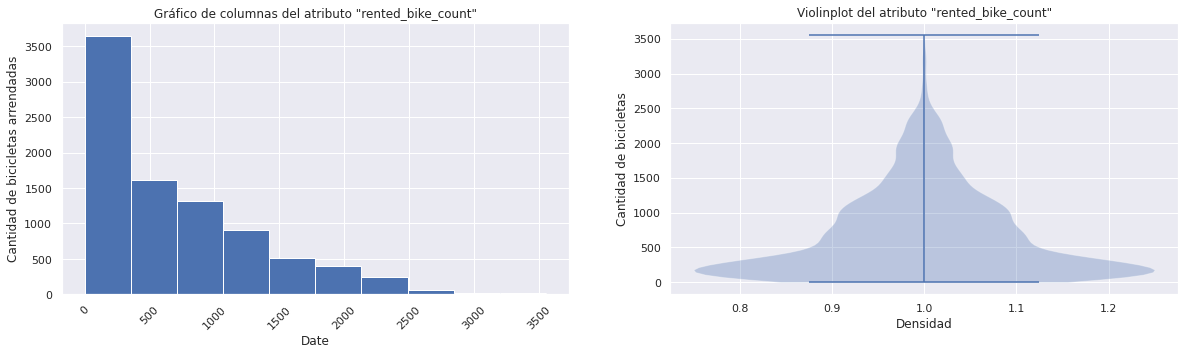

In [ ]:
### START CODE HERE ###
# Grafico para el target

x = df_data_wi["rented_bike_count"]

fig, axs = plt.subplots(1, 2, figsize = (20,5))

axs[0].hist(x)
axs[0].set_xlabel('Date')
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_ylabel('Cantidad de bicicletas arrendadas')
axs[0].set_title('Gráfico de columnas del atributo "rented_bike_count"')

axs[1].violinplot(x)
axs[1].set_xlabel('Densidad')
axs[1].set_ylabel('Cantidad de bicicletas')
axs[1].set_title('Violinplot del atributo "rented_bike_count"')

plt.grid(True)
fig.show()

Cantidad de bicicletas arrendadas en dias no funcionales: 0
['Yes' 'No']


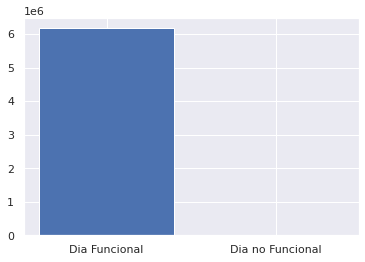

In [ ]:

DiaFuncional = df_data_wi.loc[df_data_wi['functioning_day'] == 'Yes',"rented_bike_count"].sum()
DiaNoFuncional = df_data_wi.loc[df_data_wi['functioning_day'] == 'No',"rented_bike_count"].sum()
height = [DiaFuncional,DiaNoFuncional]

bars = ('Dia Funcional', 'Dia no Funcional')
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
fig.show()

print("Cantidad de bicicletas arrendadas en dias no funcionales:",DiaNoFuncional)
print(df_data_wi['functioning_day'].unique())

Se observa que en todos los dias no funcionales no se arriendan bicicletas, por lo que se pueden eliminar directamente estos datos debido a que pueden ensuciar el resto de los datos y simplemente remplazable por un if.

In [ ]:
df_data

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


**Antes de dividir la data en training/validation/testing piense en como lo haría teniendo en consideración que ahora tenemos un problema de serie de tiempo** ¿Puede hacer la división de forma random? Comente como lo haría y luego implemente la división considerando 80/10/10 [4 Pts]

**Respuesta**: Usualmente en una serie de tiempo no se deberia dividir de forma random y se debiera dividir en sucesión (i.e. si se tienen 10 años de data, los primeros 8 para train y los siguientes 2 para test), pero como solo se tiene 365 dias de data, no se logra repetir el ciclo de las temporadas y fechas, por lo que seria mejor utilizar random igualmente para que se testee en todos los apsectos.

In [ ]:
### START CODE HERE ###
X = df_data

# Primero separamos 80:20 entrenamiento:test
df_train, df_test = train_test_split(X, test_size=0.2 , random_state=SEED)

# Luego separamos el test set en 10:10 valid:test. 
# Consideramos test_size como 0.5 (50% de los datos que quedaron anteriormente)

df_valid, df_test = train_test_split(df_test, test_size=0.5 , random_state=SEED)



## Preprocesamiento

**Defina e implemente una estrategia de preprocesamiento para las columnas considerando la información aportada por los gráficos** [4 Pts]



In [ ]:
### START CODE HERE ###

#Funcion para pasar las fechas a solo dias 0-365
def fecha_a_dia(fecha):
  dias_mes_acumulado = [0 ,31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
  return int(fecha[:2]) + dias_mes_acumulado[int(fecha[3:5]) - 1]

#funcion para pasar los dias a funcion seno y coseno
def preprocess_day(df, column):
  """Funcion que toma la columna dia y crea dos features utilizando esa variable"""
  DAYS_IN_YEAR = 365
  df['sin_day'] = np.sin(2 * np.pi * df[column].apply(fecha_a_dia) / DAYS_IN_YEAR)
  df['cos_day'] = np.cos(2 * np.pi * df[column].apply(fecha_a_dia) / DAYS_IN_YEAR)
  df.drop(columns=[column], inplace=True)
  return df

#funcion de preprocesado ordinal para las seasons y holidays
def preprocess_ordinal(df,column):
  le = OrdinalEncoder()
  df[column + "_OrdinalEncoded"] = le.fit_transform(pd.DataFrame(df, columns=[column]))
  df.drop(columns=[column], inplace=True)
  return df

#funcion que aplica todos lo preprecesados
def preprocess_all(df):

  #Eliminar todos los datos de cuando no esta en funcionamiento el rental.
  df = df.drop(df[df.functioning_day == "No"].index)
  df.drop('functioning_day', inplace=True, axis=1)\

  #Cambiar seasons y holiday a valores numericos
  df = preprocess_ordinal(df,"seasons")
  df = preprocess_ordinal(df,"holiday")

  #Cambiar las fechas a formato coseno seno, eliminando el valor año debido a que no es relevante (solo existen datos de 365 dias)
  preprocess_day(df, 'date')
  return df

In [ ]:
df_train = preprocess_all(df_train)
df_valid = preprocess_all(df_valid)
df_test = preprocess_all(df_test)

In [ ]:
df_train

,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons_OrdinalEncoded,holiday_OrdinalEncoded,sin_day,cos_day
3789,1717,21,19.6,64,1.5,1297,12.5,0.00,0.0,0.0,1.0,1.0,0.816538,-0.577292
4673,2664,17,25.6,57,3.3,919,16.4,0.87,0.0,0.0,2.0,1.0,0.313107,-0.949718
7764,1407,12,17.7,33,2.2,1556,1.2,2.37,0.0,0.0,0.0,1.0,-0.945596,0.325342
2847,781,15,20.8,42,3.1,576,7.4,2.10,0.0,0.0,1.0,1.0,0.998435,0.055917
8049,1011,9,4.7,60,0.9,1219,-2.4,0.82,0.0,0.0,0.0,1.0,-0.858764,0.512371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6384,238,0,25.7,83,2.0,2000,22.5,0.00,0.5,0.0,2.0,1.0,-0.796183,-0.605056
4720,1726,16,26.5,45,1.6,2000,13.5,1.91,0.0,0.0,2.0,1.0,0.280231,-0.959933
173,84,5,-5.8,56,2.0,1941,-13.1,0.00,0.0,0.0,3.0,1.0,-0.385663,0.922640
1244,258,20,0.3,27,0.4,2000,-16.5,0.00,0.0,0.0,3.0,1.0,0.353676,0.935368


## Entrenamiento

**Entrene una SVM y un árbol para regresión, utilice el conjunto de validación para setear los hiperparámetros de cada modelo. Para ello utilice lo aprendido en la tarea 1 y decida alguna métrica para evaluación acorde al problema** [1 Pts]

In [ ]:
### START CODE HERE ###
#Separar en x e y
y_train = df_train['rented_bike_count']
x_train = df_train.drop(columns = ['rented_bike_count'])
y_test = df_test['rented_bike_count']
x_test = df_test.drop(columns = ['rented_bike_count'])
y_valid = df_valid['rented_bike_count']
x_valid = df_valid.drop(columns = ['rented_bike_count'])


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

#Buscar mejores parametros
def MejoresParamsSVM(x_valid, y_valid):
  SVM = SVR()
  distributions = dict(C=[0.5,0.9,1,1.1,1.5,2,3,4,5,6,7,8,9,10],gamma=['scale','auto'],epsilon=[0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4])
  clf = RandomizedSearchCV(SVM, distributions, random_state=SEED)
  search = clf.fit(x_valid, y_valid)
  return search.best_params_

def MejoresParamsTree(x_valid, y_valid): 
  Tree = DecisionTreeRegressor()
  distributions = dict(
                       min_samples_leaf = [1,2,3,4,5,6,7,8,9,10],
                       max_features = ["auto","log2","sqrt",None],
                       max_leaf_nodes = [None,10,20,30,40,50,60,70,80,90,100])
  clf = RandomizedSearchCV(Tree, distributions, random_state=0)
  search = clf.fit(x_valid, y_valid)
  return search.best_params_


In [ ]:
MejoresParamsSVM(x_valid,y_valid)

{'C': 9, 'epsilon': 0.025, 'gamma': 'scale'}

In [ ]:
MejoresParamsTree(x_valid,y_valid)

{'max_features': 'auto', 'max_leaf_nodes': 50, 'min_samples_leaf': 5}

In [ ]:
#modelo SVM
SVM = SVC()
#Entrenar el modelo
SVM.fit(x_train,y_train)

#Modelo de arbol
Tree = DecisionTreeRegressor(
 max_features = 'auto',
 max_leaf_nodes = 50,
 min_samples_leaf = 5,
 min_weight_fraction_leaf = 0)
#Entrenar el modelo
Tree.fit(x_train,y_train)

DecisionTreeRegressor(max_features='auto', max_leaf_nodes=50,
                      min_samples_leaf=5, min_weight_fraction_leaf=0)

## Predicción

**Realice la predicción para el conjunto de testing considerando ambos modelos y muestre gráficamente el resultado**. También mostrar el score obtenido para cada modelo considerando la métrica seleccionada anteriormente [2 Pts]

In [ ]:
from sklearn import metrics
### START CODE HERE ###
# Tomar las metricas del modelo 
SVM_results = SVM.predict(x_test)
Tree_results = Tree.predict(x_test)

print('SVM:')
print('MAE:', metrics.mean_absolute_error(y_test,SVM_results))
print('MSE:', metrics.mean_squared_error(y_test, SVM_results))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, SVM_results)))
print('-------------------------------')
print('Tree:')
print('MAE:', metrics.mean_absolute_error(y_test,Tree_results))
print('MSE:', metrics.mean_squared_error(y_test, Tree_results))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, Tree_results)))



SVM:
MAE: 638.1260404280619
MSE: 808457.2818073722
RMSE: 899.1425258585939
-------------------------------
Tree:
MAE: 199.56148466050507
MSE: 89041.36580869023
RMSE: 298.39799900249034


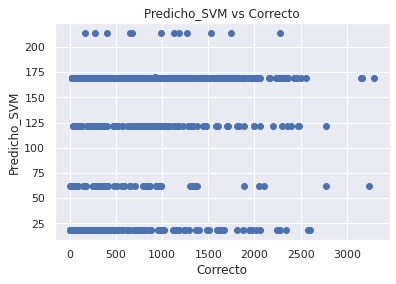

In [ ]:
plt.scatter(y_test,SVM_results)
plt.title('Predicho_SVM vs Correcto')
plt.xlabel('Correcto')
plt.ylabel('Predicho_SVM')
plt.show()

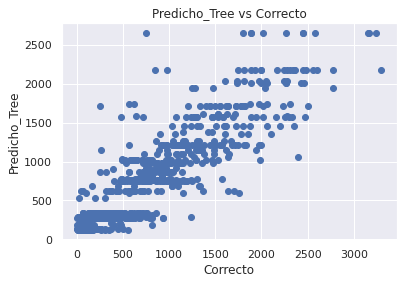

In [ ]:
plt.scatter(y_test,Tree_results)
plt.title('Predicho_Tree vs Correcto')
plt.xlabel('Correcto')
plt.ylabel('Predicho_Tree')
plt.show()

## Explainability

**Finalmente, esto se escapa un poco de los contenidos del curso, pero utilice SHAP para mostrar la importancia de cada feature para cada modelo gráficamente**. Comente los gráficos y también investigue para que sirve y cuál es la principal diferencia entre `lime` y `SHAP` [2 Pts]

*Se recomienda revisar [SHAP](https://github.com/slundberg/shap) y [lime](https://github.com/marcotcr/lime)*

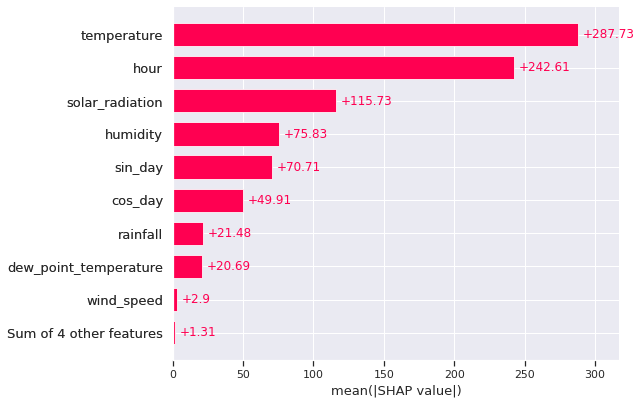

In [ ]:
### START CODE HERE ###
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(Tree)
shap_values = explainer(x_train)
# visualize the first prediction's explanation
shap.plots.bar(shap_values)

El grafico nos muestra que tanto "peso" tiene cada feature, lo cual coincide un poco con la logica, a mayor temperatura mas se anda en bicicleta y dependiendo de la hora del dia tambien se anda o no en bicicleta

`SHAP`: SHAP es mejor para explicar todo un modelo

`Lime`: lime es mejor para explicar una solo prediccion

**Investigue y grafique el resultado de utilizar Permutation Feature Importance para ambos modelos**. Comente el gráfico e identifique ventajas y desventajas de esta técnica [2 Pts]

*Se recomienda revisar [Permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html)*

In [ ]:
### START CODE HERE ###
from sklearn.inspection import permutation_importance
r = permutation_importance(Tree, x_train, y_train,
                           n_repeats=10,
                           random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{x_train.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")


hour    0.758 +/- 0.019
temperature0.522 +/- 0.010
solar_radiation0.212 +/- 0.008
humidity0.187 +/- 0.010
cos_day 0.142 +/- 0.003
sin_day 0.114 +/- 0.005
dew_point_temperature0.026 +/- 0.002
rainfall0.025 +/- 0.001
wind_speed0.004 +/- 0.001
holiday_OrdinalEncoded0.004 +/- 0.001


[0.75845319 0.52241588 0.18679957 0.00402189 0.         0.02580896
 0.21172466 0.02525973 0.         0.         0.00352936 0.11382646
 0.14247805]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text major ticklabel objects>)

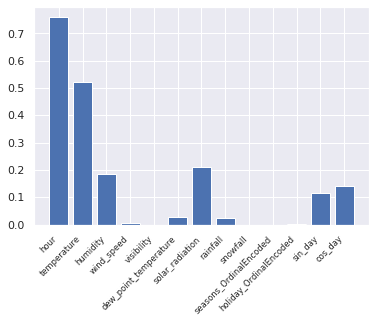

In [ ]:
print(r.importances_mean)
plt.bar(x_train.columns,r.importances_mean)
plt.show
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-small'  
)


`Permutation Feature Importance`: tecnica que mide la importancia de cada feature atravez de permutaciones entre estas, tiene un tiempo de ejecucion mayor debido a que realiza varias pruebas dentro del mismo modelo, pero esto mismo asegura una mayor relacion con el modelo

## Preguntas finales

**Compare la regresión lineal con árboles para regresión**. Similitudes y principales diferencias [1 Pts]

`Respuesta`: los arboles generan cotas por donde pueden predecir limitando su capacidad de predecir a futuro como se puede observar en el scatter plot de los resultados, por otra parte SVM no se limita por cotas pero es mas lento su computo.

**Si tuvieras que estimar el costo de venta para una casa y tuvieras dos algoritmos, una SVM con un MSE de 13000 y un árbol de regresión con MSE 16000. ¿Cuál algoritmo utilizaría considerando que tiene que presentar y explicar los resultados al equipo de la empresa en la que trabaja?**. Puede realizar cualquier supuesto [1 Pts]

`Respuesta`: Usaria el algoritmo SVM con un MSE de 13000, debido a que entrego mejores resultados frente al problema propuesto y debido a que ambos algoritmos pueden dar soluciones validas, a su vez el SVM no impone cotas como lo hace el arbol y ademas asumiendo que se realizo con datos antiguos, el svm es mejor para extrapolar a futuro, en cambio el arbol se ve limitado.

# 1.2) Árboles y SVM para clasificación 📊


<img src="https://drive.google.com/uc?id=15s7kbIe78aPmg4cP0srOOawB_I3-BjRT" width="50%"/>

[Referencia](https://www.lavanguardia.com/comer/tendencias/20190605/462680078779/fruta-horas-adelgazar-dietas-mitos.html)

Para la segunda parte de la tarea trabajaremos con un dataset que contiene información de frutas extraterrestres y la finalidad es predecir la estación del año en base a las propiedades de la fruta.

La data corresponde a 42.748 instancias las cuales tienen relación con frutas extraterrestres


Para el dataset se tienen 13 features :

* `edible-poisonous`: Edible=e, Poisonous=p
* `cap-diameter`: Diámetro [cm]
* `cap-shape`: Bell=b, Conical=c, Convex=x, Flat=f, Sunken=s, Spherical=p, Others=o
* `cap-color`: Brown=n, Buff=b, Gray=g, Green=r, Pink=p, Purple=u, Red=e, White=w, Yellow=y, Blue=l, Orange=o, Black=k
* `does-bruise-or-bleed`: Bruises-or-bleeding=t, No=f
* `gill-attachment`: Adnate=a, Adnexed=x, Decurrent=d, Free=e, Sinuate=s, Pores=p, None=f
* `gill-color`: See cap-color + None=f
* `stem-height`: Altura [cm]
* `stem-width`: Ancho [mm]
* `stem-color`: See cap-color + None=f
* `has-ring`: Ring=t, None=f
* `ring-type`: Cobwebby=c, Evanescent=e, Flaring=r, Grooved=g, Large=l, Pendant=p, Sheathing=s, Zone=z, Scaly=y, Movable=m, None=f
* `habitat`: Grasses=g, Leaves=l, Meadows=m, Paths=p, Heaths=h, Urban=u, Waste=w, Woods=d

y un target:

* `season`: Spring=s, Summer=u, Autumn=a, Winter=w

## Carga de datos

Como es costumbre, lo primero que vamos a hacer es cargar la data y explorar un poco su contenido

In [ ]:
# Cargar la data que corresponde a un csv
PATH_TO_CSV = os.path.join(path, "tarea_2_weather_fruit.csv")
df_data = pd.read_csv(PATH_TO_CSV)

In [ ]:
df_data.head()

,edible-poisonous,cap-diameter,cap-shape,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,p,5.75,x,n,t,s,w,6.13,14.93,w,f,f,d,a
1,p,2.27,o,g,f,f,f,0.00,0.00,f,f,f,d,s
2,p,5.59,c,y,t,x,p,5.47,11.27,w,f,f,d,a
3,p,0.74,x,p,f,a,n,4.33,0.98,k,f,f,d,a
4,p,9.60,x,n,f,a,w,10.84,28.52,w,f,f,d,u


## Exploración de la data

In [ ]:
# Contar la cantidad de null en las columnas (si hubieran muchos habria que buscar alguna forma de lidear con ello). 
df_data.isna().sum()

edible-poisonous           0
cap-diameter               0
cap-shape                  0
cap-color                  0
does-bruise-or-bleed       0
gill-attachment         6940
gill-color                 0
stem-height                0
stem-width                 0
stem-color                 0
has-ring                   0
ring-type               1719
habitat                    0
season                     0
dtype: int64

In [ ]:
# Eliminar las filas con valores NaN
df_data.dropna(subset = ["gill-attachment","ring-type"], inplace=True)
df_data.isna().sum()

edible-poisonous        0
cap-diameter            0
cap-shape               0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

In [ ]:
# Exploración general
# Mostrar el numero de ejemplos que tenemos
print(f"Number of examples: {len(df_data)}")

# Mostrar las dimensiones de la data
print(f"Shape of the data: {df_data.shape}")
print("-------------")
# Mostrar los tipos de dato de cada columna
print(f"Data Types: {df_data.dtypes}")
print("-------------")
df_data.describe()

Number of examples: 34333
Shape of the data: (34333, 14)
-------------
Data Types: edible-poisonous         object
cap-diameter            float64
cap-shape                object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-color               object
stem-height             float64
stem-width              float64
stem-color               object
has-ring                 object
ring-type                object
habitat                  object
season                   object
dtype: object
-------------


,cap-diameter,stem-height,stem-width
count,34333.000000,34333.000000,34333.000000
mean,6.963783,6.446005,12.767606
std,5.418298,3.042855,10.571372
min,0.470000,0.000000,0.000000
25%,3.690000,4.650000,5.720000
50%,6.080000,5.890000,10.490000
75%,8.640000,7.490000,16.890000
max,62.340000,27.850000,103.910000


**Genere gráficos individuales y/o de pares para explorar más la data**. Comente lo que observa de cada gráfico [3 Pts]

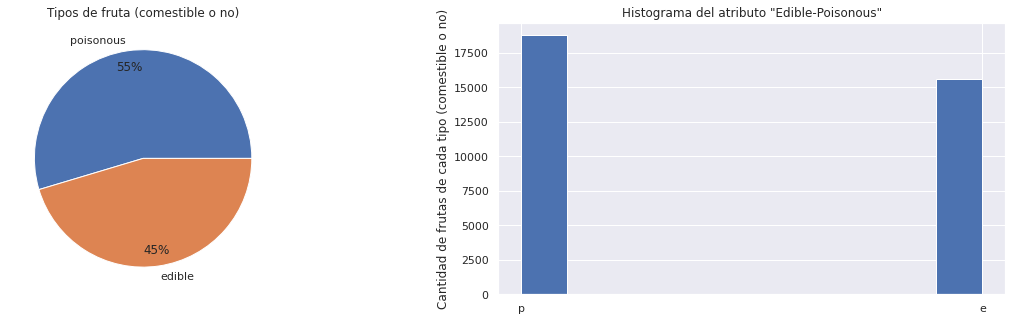

In [ ]:
### START CODE HERE ###
x = df_data["edible-poisonous"]

fig, axs = plt.subplots(1, 2, figsize = (20,5))

axs[0].set_title('Tipos de fruta (comestible o no)')
axs[0].pie(x.value_counts(), labels= ['poisonous', 'edible'], autopct='%1.0f%%', pctdistance=0.85)

axs[1].hist(x)
axs[1].set_ylabel('Cantidad de frutas de cada tipo (comestible o no)')
axs[1].set_title('Histograma del atributo "Edible-Poisonous"')

plt.grid(True)
fig.show()

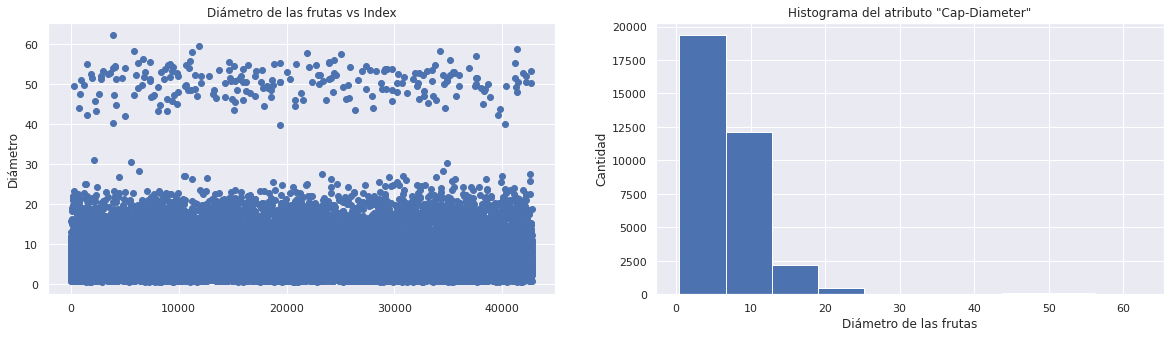

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (20,5))

axs[0].set_title('Diámetro de las frutas vs Index')
axs[0].scatter(df_data.index, df_data["cap-diameter"])
axs[0].set_ylabel('Diámetro')

x = df_data["cap-diameter"]

axs[1].hist(x)
axs[1].set_ylabel('Cantidad')
axs[1].set_xlabel('Diámetro de las frutas')
axs[1].set_title('Histograma del atributo "Cap-Diameter"')

plt.grid(True)
fig.show()

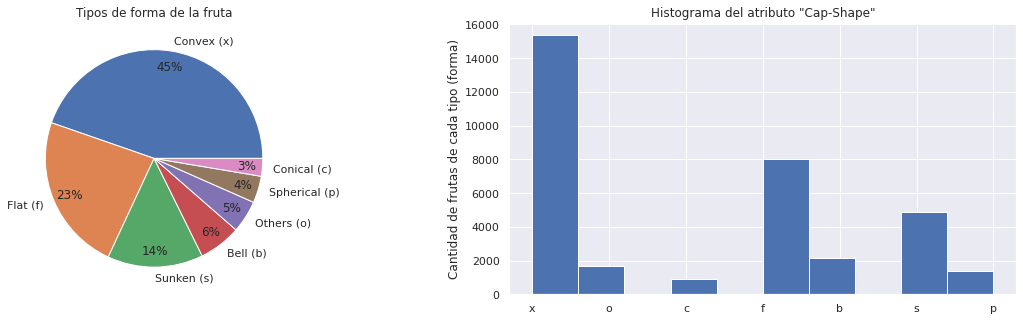

In [ ]:
### START CODE HERE ###
x = df_data["cap-shape"]

fig, axs = plt.subplots(1, 2, figsize = (20,5))

axs[0].set_title('Tipos de forma de la fruta')
axs[0].pie(x.value_counts(), labels= ['Convex (x)', 'Flat (f)', 'Sunken (s)', 'Bell (b)', 'Others (o)', 'Spherical (p)', 'Conical (c)'], autopct='%1.0f%%', pctdistance=0.85)

axs[1].hist(x)
axs[1].set_ylabel('Cantidad de frutas de cada tipo (forma)')
axs[1].set_title('Histograma del atributo "Cap-Shape"')

plt.grid(True)
fig.show()

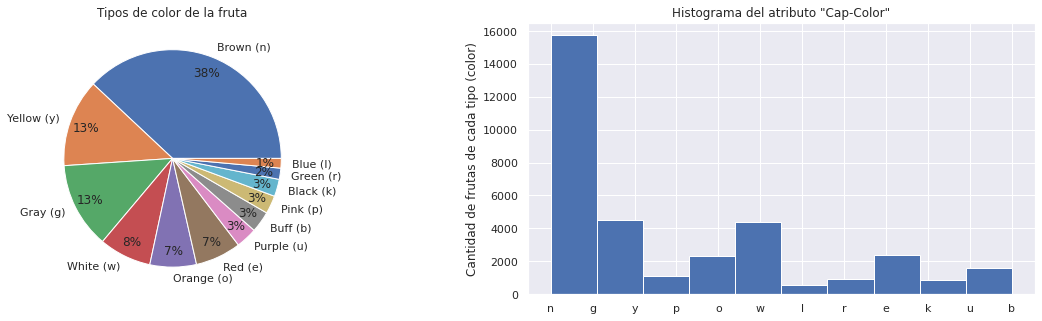

In [ ]:
### START CODE HERE ###
x = df_data["cap-color"]

fig, axs = plt.subplots(1, 2, figsize = (20,5))

axs[0].set_title('Tipos de color de la fruta')
axs[0].pie(x.value_counts(), labels= ['Brown (n)', 'Yellow (y)', 'Gray (g)', 
                                      'White (w)', 'Orange (o)', 'Red (e)',
                                      'Purple (u)', 'Buff (b)', 'Pink (p)',
                                      'Black (k)', 'Green (r)', 'Blue (I)'],
            autopct='%1.0f%%', pctdistance=0.85)

axs[1].hist(x)
axs[1].set_ylabel('Cantidad de frutas de cada tipo (color)')
axs[1].set_title('Histograma del atributo "Cap-Color"')

plt.grid(True)
fig.show()

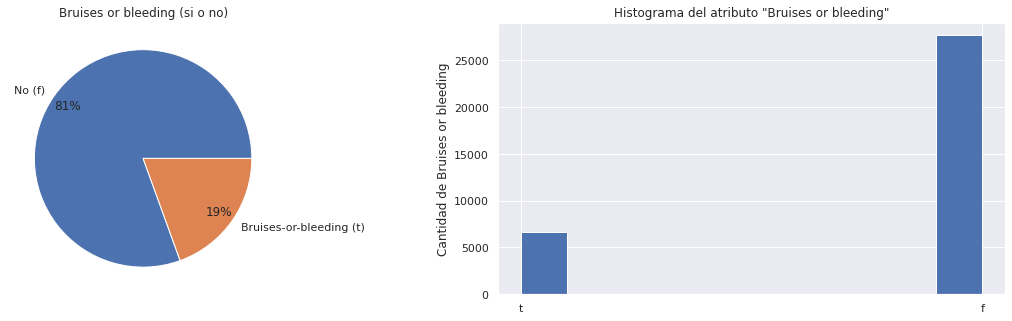

In [ ]:
### START CODE HERE ###
x = df_data["does-bruise-or-bleed"]

fig, axs = plt.subplots(1, 2, figsize = (20,5))

axs[0].set_title('Bruises or bleeding (si o no)')
axs[0].pie(x.value_counts(), labels= ['No (f)', 'Bruises-or-bleeding (t)'], autopct='%1.0f%%', pctdistance=0.85)

axs[1].hist(x)
axs[1].set_ylabel('Cantidad de Bruises or bleeding')
axs[1].set_title('Histograma del atributo "Bruises or bleeding"')

plt.grid(True)
fig.show()

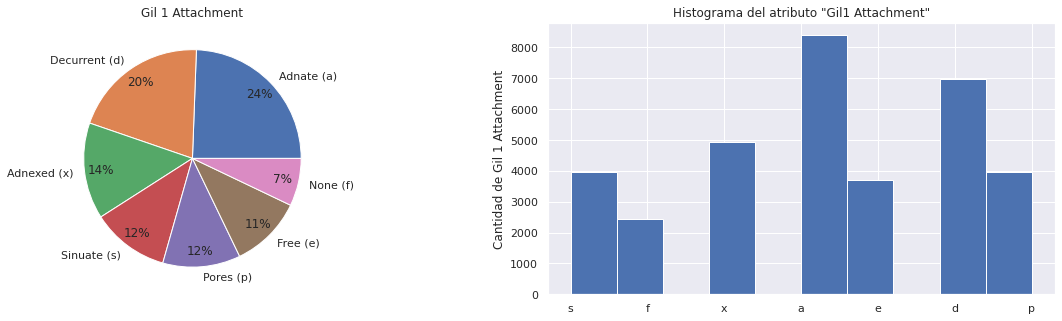

In [ ]:
### START CODE HERE ###
x = df_data["gill-attachment"]

fig, axs = plt.subplots(1, 2, figsize = (20,5))

axs[0].set_title('Gil 1 Attachment')
axs[0].pie(x.value_counts(), labels= ["Adnate (a)", "Decurrent (d)", "Adnexed (x)", 'Sinuate (s)', 'Pores (p)', 'Free (e)', 'None (f)'], autopct='%1.0f%%', pctdistance=0.85)

axs[1].hist(x)
axs[1].set_ylabel('Cantidad de Gil 1 Attachment')
axs[1].set_title('Histograma del atributo "Gil1 Attachment"')

plt.grid(True)
fig.show()

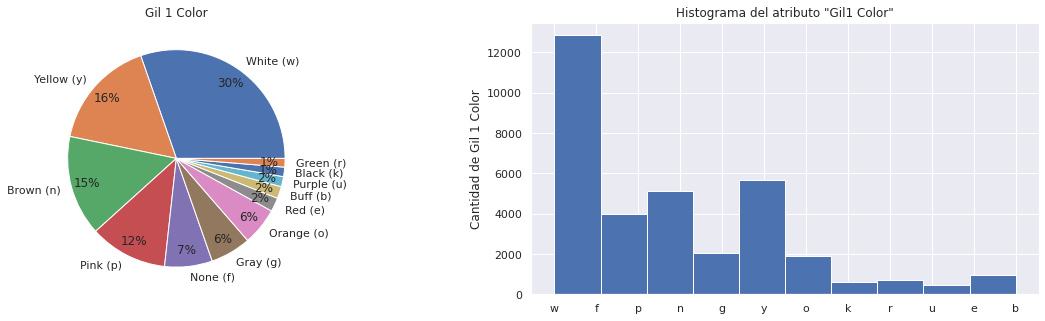

In [ ]:
### START CODE HERE ###
x = df_data["gill-color"]

fig, axs = plt.subplots(1, 2, figsize = (20,5))

axs[0].set_title('Gil 1 Color')
axs[0].pie(x.value_counts(), labels=['White (w)', 'Yellow (y)', 'Brown (n)', 
                                     'Pink (p)', 'None (f)', 'Gray (g)',
                                     'Orange (o)', 'Red (e)', 'Buff (b)',
                                     'Purple (u)', 'Black (k)', 'Green (r)']
           ,autopct='%1.0f%%', pctdistance=0.85)

axs[1].hist(x)
axs[1].set_ylabel('Cantidad de Gil 1 Color')
axs[1].set_title('Histograma del atributo "Gil1 Color"')

plt.grid(True)
fig.show()

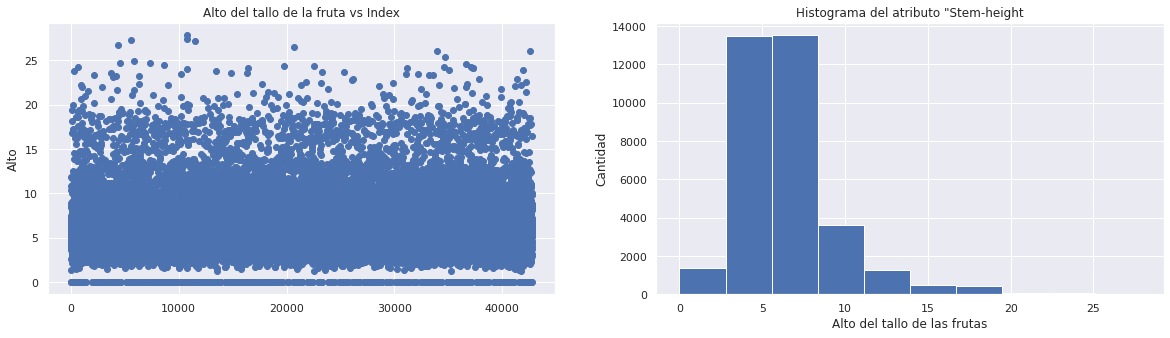

In [ ]:
### START CODE HERE ###
fig, axs = plt.subplots(1, 2, figsize = (20,5))

axs[0].scatter(df_data.index, df_data["stem-height"])
axs[0].set_title('Alto del tallo de la fruta vs Index')
axs[0].set_ylabel('Alto')

axs[1].hist(df_data["stem-height"])
axs[1].set_ylabel('Cantidad')
axs[1].set_xlabel('Alto del tallo de las frutas')
axs[1].set_title('Histograma del atributo "Stem-height')

plt.grid(True)
fig.show()

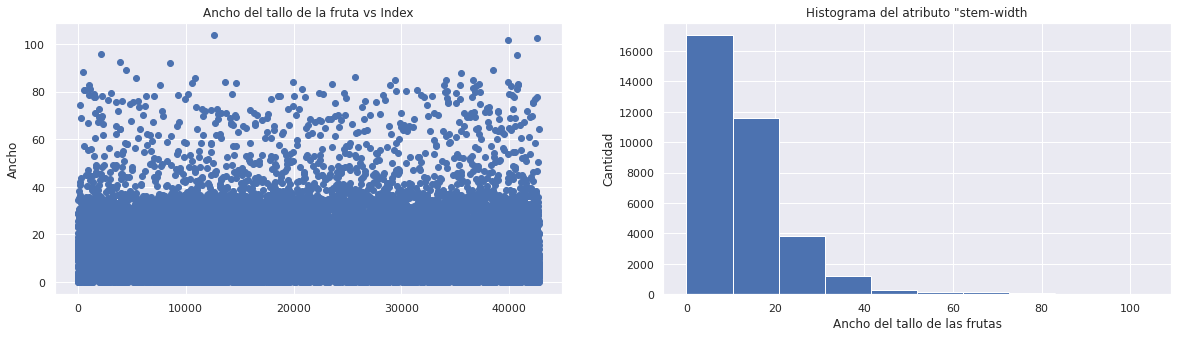

In [ ]:
### START CODE HERE ###
fig, axs = plt.subplots(1, 2, figsize = (20,5))

axs[0].scatter(df_data.index, df_data["stem-width"])
axs[0].set_title('Ancho del tallo de la fruta vs Index')
axs[0].set_ylabel('Ancho')

axs[1].hist(df_data["stem-width"])
axs[1].set_ylabel('Cantidad')
axs[1].set_xlabel('Ancho del tallo de las frutas')
axs[1].set_title('Histograma del atributo "stem-width')

plt.grid(True)
fig.show()

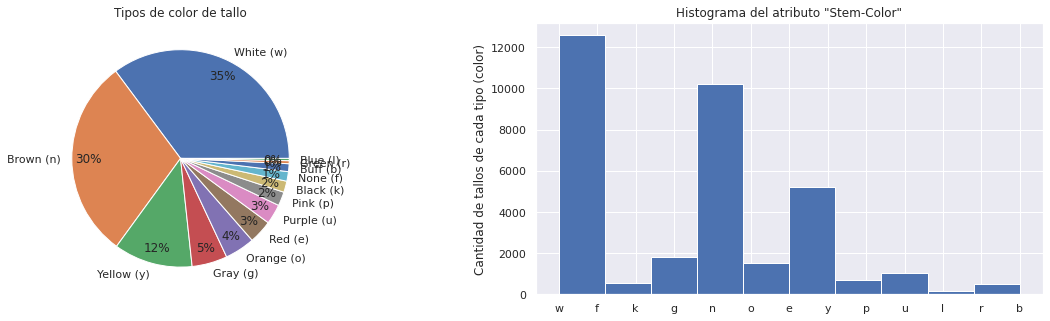

In [ ]:
### START CODE HERE ###
x = df_data["stem-color"]

fig, axs = plt.subplots(1, 2, figsize = (20,5))

axs[0].set_title('Tipos de color de tallo')
axs[0].pie(x.value_counts(), labels= ['White (w)', 'Brown (n)', 'Yellow (y)',
                                      'Gray (g)', 'Orange (o)', 'Red (e)',
                                      'Purple (u)', 'Pink (p)', 'Black (k)',
                                      'None (f)', 'Buff (b)', 'Green (r)', 
                                      'Blue (I)'],
            autopct='%1.0f%%', pctdistance=0.85)

axs[1].hist(x)
axs[1].set_ylabel('Cantidad de tallos de cada tipo (color)')
axs[1].set_title('Histograma del atributo "Stem-Color"')

plt.grid(True)
fig.show()

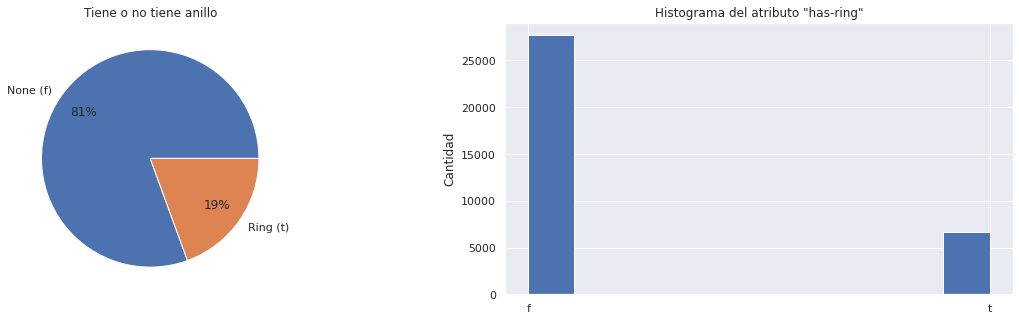

In [ ]:
### START CODE HERE ###
x = df_data["has-ring"]

fig, axs = plt.subplots(1, 2, figsize = (20,5))

axs[0].set_title('Tiene o no tiene anillo')
axs[0].pie(x.value_counts(), labels= ["None (f)", "Ring (t)"], autopct='%1.0f%%', pctdistance=0.75)

axs[1].hist(x)
axs[1].set_ylabel('Cantidad')
axs[1].set_title('Histograma del atributo "has-ring"')

plt.grid(True)
fig.show()

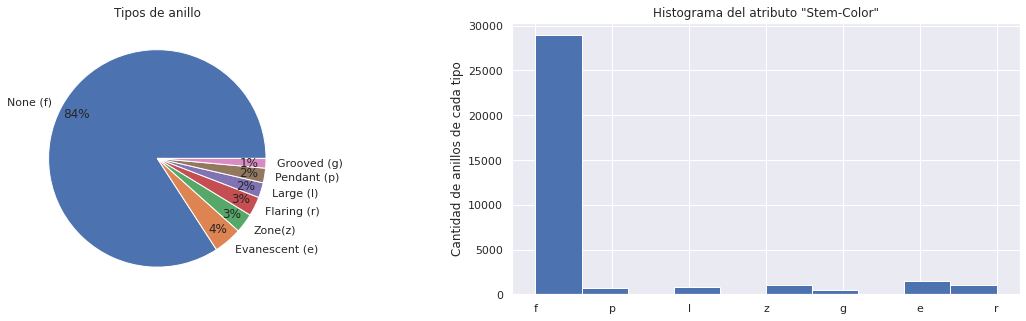

In [ ]:
### START CODE HERE ###
x = df_data["ring-type"]

fig, axs = plt.subplots(1, 2, figsize = (20,5))

axs[0].set_title('Tipos de anillo')
axs[0].pie(x.value_counts(), labels= ['None (f)', 'Evanescent (e)', 'Zone(z)',
                                      'Flaring (r)', 'Large (l)', 'Pendant (p)',
                                      'Grooved (g)'],
            autopct='%1.0f%%', pctdistance=0.85)

axs[1].hist(x)
axs[1].set_ylabel('Cantidad de anillos de cada tipo')
axs[1].set_title('Histograma del atributo "Stem-Color"')

plt.grid(True)
fig.show()

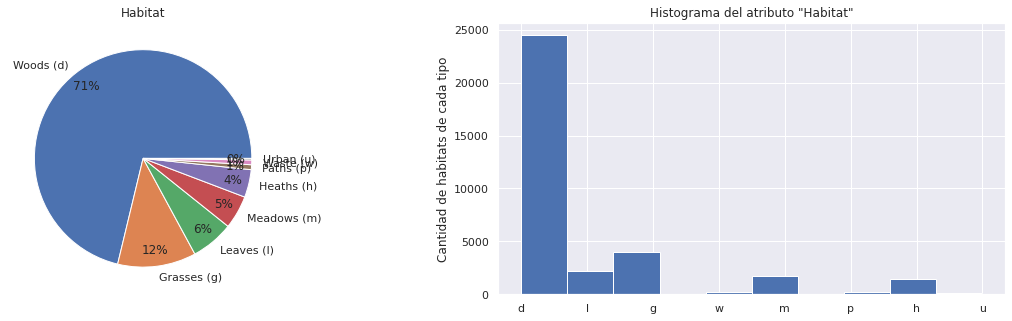

In [ ]:
### START CODE HERE ###
x = df_data["habitat"]

fig, axs = plt.subplots(1, 2, figsize = (20,5))

axs[0].set_title('Habitat')
axs[0].pie(x.value_counts(), labels= ['Woods (d)', 'Grasses (g)', 'Leaves (I)', 'Meadows (m)',
                                      'Heaths (h)', 'Paths (p)', 'Waste (w)', 'Urban (u)'],
            autopct='%1.0f%%', pctdistance=0.85)

axs[1].hist(x)
axs[1].set_ylabel('Cantidad de habitats de cada tipo')
axs[1].set_title('Histograma del atributo "Habitat"')

plt.grid(True)
fig.show()

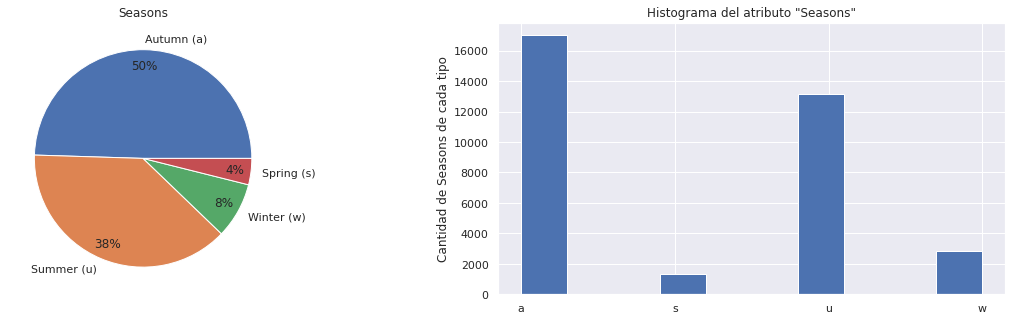

In [ ]:
### START CODE HERE ###
x = df_data["season"]

fig, axs = plt.subplots(1, 2, figsize = (20,5))

axs[0].set_title('Seasons')
axs[0].pie(x.value_counts(), labels= ['Autumn (a)', 'Summer (u)', 'Winter (w)', 'Spring (s)'],
            autopct='%1.0f%%', pctdistance=0.85)

axs[1].hist(x)
axs[1].set_ylabel('Cantidad de Seasons de cada tipo')
axs[1].set_title('Histograma del atributo "Seasons"')

plt.grid(True)
fig.show()

**Divida la data en training/validation/testing considerando un split 80/10/10 respectivamente** [1 Pts]

In [ ]:
### START CODE HERE ###
X = df_data

# Primero separamos 80:20 entrenamiento:test
df_train, df_test = train_test_split(X, test_size=0.2 , random_state=SEED)

# Luego separamos el test set en 10:10 valid:test. 
# Consideramos test_size como 0.5 (50% de los datos que quedaron anteriormente)

df_valid, df_test = train_test_split(df_test, test_size=0.5 , random_state=SEED)

## Preprocesamiento

**Defina e implemente una estrategia de preprocesamiento para las columnas considerando la información aportada por los gráficos** [6 Pts]

In [ ]:
### START CODE HERE ###

#funcion de preprocesado ordinal para las variables categóricas t o e (1) y f o p (0)
def preprocess_binary(df, column):
  print("Ejecutando Binary Encoding en la columna " + str(column))
  feature = "{featurename}_binary".format(featurename = column)
  
  if column == "edible-poisonous":
    df[feature] = (df[column] == 'e').astype(int)
  else:
    df[feature] = (df[column] == 't').astype(int)
  
  df.drop(columns=[column], inplace=True)
  return df
  
#funcion de preprocesado ordinal para las variables categóricas
def preprocess_label(df, column):
  print("Ejecutando Encoding de label de la columna " + str(column))
  le = LabelEncoder()
  feature = "{featurename}_labelenc".format(featurename = column)
  df[feature] = le.fit_transform(pd.DataFrame(df, columns=[column]))
  df.drop(columns=[column], inplace=True)
  return df

#funcion que aplica todos lo preproecesados
def preprocess_all(df):
  df = preprocess_binary(df, "edible-poisonous")
  df = preprocess_binary(df, "does-bruise-or-bleed")
  df = preprocess_binary(df, "has-ring")
  df = preprocess_label(df, "cap-shape")
  df = preprocess_label(df, "cap-color")
  df = preprocess_label(df, "gill-attachment")
  df = preprocess_label(df, "gill-color")
  df = preprocess_label(df, "stem-color")
  df = preprocess_label(df, "ring-type")
  df = preprocess_label(df, "habitat")
  df = preprocess_label(df, "season")
  return df

In [ ]:
df_train = preprocess_all(df_train)
df_valid = preprocess_all(df_valid)
df_test = preprocess_all(df_test)

Ejecutando Binary Encoding en la columna edible-poisonous
Ejecutando Binary Encoding en la columna does-bruise-or-bleed
Ejecutando Binary Encoding en la columna has-ring
Ejecutando Encoding de label de la columna cap-shape
Ejecutando Encoding de label de la columna cap-color
Ejecutando Encoding de label de la columna gill-attachment
Ejecutando Encoding de label de la columna gill-color
Ejecutando Encoding de label de la columna stem-color
Ejecutando Encoding de label de la columna ring-type
Ejecutando Encoding de label de la columna habitat
Ejecutando Encoding de label de la columna season
Ejecutando Binary Encoding en la columna edible-poisonous
Ejecutando Binary Encoding en la columna does-bruise-or-bleed
Ejecutando Binary Encoding en la columna has-ring
Ejecutando Encoding de label de la columna cap-shape
Ejecutando Encoding de label de la columna cap-color
Ejecutando Encoding de label de la columna gill-attachment
Ejecutando Encoding de label de la columna gill-color
Ejecutando Enc

In [ ]:
df_train

,cap-diameter,stem-height,stem-width,edible-poisonous_binary,does-bruise-or-bleed_binary,has-ring_binary,cap-shape_labelenc,cap-color_labelenc,gill-attachment_labelenc,gill-color_labelenc,stem-color_labelenc,ring-type_labelenc,habitat_labelenc,season_labelenc
14740,3.93,4.55,6.87,1,0,0,6,1,0,6,1,1,4,3
12007,5.70,5.52,20.28,1,0,0,1,5,3,2,6,1,0,1
17372,20.01,5.83,33.66,0,0,0,6,5,4,11,6,1,0,0
25906,1.47,6.71,1.80,1,0,0,6,11,0,10,12,1,0,0
34539,6.93,6.23,6.61,1,0,1,6,5,6,10,6,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,10.83,5.47,14.94,0,1,0,2,5,1,5,6,1,2,2
7982,6.63,11.42,12.36,0,0,1,0,10,2,10,11,3,0,0
20683,6.02,5.00,19.29,1,0,0,3,5,3,2,6,1,0,1
1545,20.70,5.12,39.66,0,0,0,2,3,4,11,6,1,0,3


## Entrenamiento

**Entrene una SVM y un árbol para regresión, utilice el conjunto de validación para setear los hiperparámetros de cada modelo. Para ello utilice lo aprendido en la tarea 1 y seleccione una métrica para evaluación acorde al problema** [2 Pts]

In [ ]:
### START CODE HERE ###
#Separar en x e y
y_train = df_train['season_labelenc']
x_train = df_train.drop(columns = ['season_labelenc'])
y_test = df_test['season_labelenc']
x_test = df_test.drop(columns = ['season_labelenc'])
y_valid = df_valid['season_labelenc']
x_valid = df_valid.drop(columns = ['season_labelenc'])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

#Buscar mejores parametros
def MejoresParamsSVM(x_valid, y_valid):
  SVM = SVR()
  distributions = dict(C=[0.5,0.9,1,1.1,1.5,2,3,4,5,6,7,8,9,10],gamma=['scale','auto'],epsilon=[0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4])
  clf = RandomizedSearchCV(SVM, distributions, random_state=SEED)
  search = clf.fit(x_valid, y_valid)
  return search.best_params_

def MejoresParamsTree(x_valid, y_valid): 
  Tree = DecisionTreeClassifier()
  distributions = dict(
                       min_samples_leaf = [1,2,3,4,5,6,7,8,9,10],
                       max_features = ["auto","log2","sqrt",None],
                       max_leaf_nodes = [None,10,20,30,40,50,60,70,80,90,100])
  clf = RandomizedSearchCV(Tree, distributions, random_state=0)
  search = clf.fit(x_valid, y_valid)
  return search.best_params_

In [ ]:
MejoresParamsSVM(x_valid,y_valid)

{'C': 6, 'epsilon': 0.35, 'gamma': 'scale'}

In [ ]:
MejoresParamsTree(x_valid, y_valid)

{'max_features': 'log2', 'max_leaf_nodes': 40, 'min_samples_leaf': 10}

In [ ]:
#modelo SVM
SVM = SVC()
#Entrenar el modelo
SVM.fit(x_train,y_train)

#Modelo de arbol
Tree = DecisionTreeClassifier(
 max_features = 'log2',
 max_leaf_nodes = 40,
 min_samples_leaf = 10,
 min_weight_fraction_leaf = 0)
#Entrenar el modelo
Tree.fit(x_train,y_train)

DecisionTreeClassifier(max_features='log2', max_leaf_nodes=40,
                       min_samples_leaf=10, min_weight_fraction_leaf=0)

## Predicción

**Realice la predicción para el conjunto de testing cosiderando ambos modelos y compute la matriz de confusión**. También mostrar el score obtenido para la métrica seleccionada anteriormente [2 Pts]

In [ ]:
### START CODE HERE ###
from sklearn import metrics

# Tomar las metricas del modelo 
SVM_results = SVM.predict(x_test)
Tree_results = Tree.predict(x_test)

print('SVM:')
print('MAE:', metrics.mean_absolute_error(y_test,SVM_results))
print('MSE:', metrics.mean_squared_error(y_test, SVM_results))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, SVM_results)))
print('-------------------------------')
print('Tree:')
print('MAE:', metrics.mean_absolute_error(y_test,Tree_results))
print('MSE:', metrics.mean_squared_error(y_test, Tree_results))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, Tree_results)))


SVM:
MAE: 0.9959231217239372
MSE: 2.1520093185789166
RMSE: 1.4669728418000507
-------------------------------
Tree:
MAE: 0.9944670937682003
MSE: 2.1674432149097265
RMSE: 1.4722239010794949


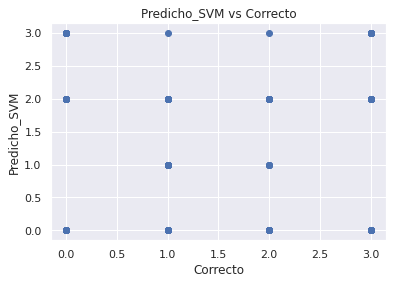

In [ ]:
plt.scatter(y_test,SVM_results)
plt.title('Predicho_SVM vs Correcto')
plt.xlabel('Correcto')
plt.ylabel('Predicho_SVM')
plt.show()

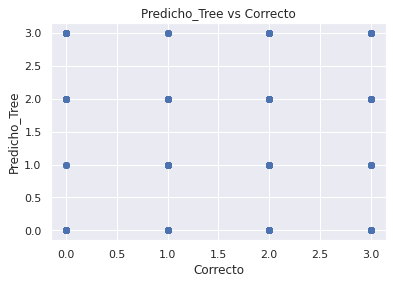

In [ ]:
plt.scatter(y_test,Tree_results)
plt.title('Predicho_Tree vs Correcto')
plt.xlabel('Correcto')
plt.ylabel('Predicho_Tree')
plt.show()

## Explainability

**Seleccione un dato del conjunto de testing, puede ser cualquiera y utilice `lime` para explicar la predicción de ambos modelos para ese caso en particular** [3 Pts]

In [ ]:
from lime import lime_tabular

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = lime_tabular.LimeTabularExplainer(x_train, mode="classification")
                                              #,
                                              #class_names=["a", "s", "u", "w"],
                                              #feature_names=x_train.columns)
shap_values = explainer(x_train)
# visualize the first prediction's explanation
shap.plots.bar(shap_values)

TypeError: ignored

**Investige e implemente Partial Dependence Plot para ambos modelos considerando alguna(s) feature(s) que considere interesante**. Identifique ventajas y desventajas de esta técnica [3 Pts]

*Se recomienda revisar [Partial Dependence Plots](https://scikit-learn.org/stable/modules/partial_dependence.html)*

In [ ]:
### START CODE HERE ###


`Partial dependency plot`: 

# 2) Desafío  🏆



[Loan Prediction](https://www.kaggle.com/competitions/tarea2ml2022/overview)

<img src="https://drive.google.com/uc?id=1qXEJ658rip9sG_YqjaYeDxAUnb0YA3ro" width="60%"/>

**La nota de este apartado se hará en base a la posición del ranking obtenido en la plataforma de `Kaggle`** [60 Pts]

*Todo el código tiene que estar presente en ese apartado incluyendo la generación del archivo para subirlo a la plataforma, pueden agregar la cantidad de celdas que requieran y se valora que incluyan comentarios a los resultados obtenidos* 

---
Hint 1: Algunos algoritmos de sklearn tienen un parámetro en la función para controlar el desbalance de clases. Si no se puede, algo simple que se podría probar es el `Over-sampling` o `Under-sampling`, investigue como utilizarlo (sklearn ya tiene esas funciones implementadas)


---
Hint 2: Puede que tengan datos faltantes en el dataset por lo que se recomienda buscar técnicas de `Imputation`



---
Hint 3: Utilizar lo aprendido en la tarea 1. (Puede 
utilizar cualquier algoritmo que ya haya sido revisado)



In [ ]:
### START CODE HERE ###

#El codigo fue realizado en la pltaforma de kaggle, debido a una falla en la lectura del archivo desde collab, aqui hay una copia no funcional.

#encontrar ruta de archivos
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#cargar archivos
df = pd.read_csv('../input/tarea2ml2022/loan_train.csv')

df_test = pd.read_csv('../input/tarea2ml2022/loan_test.csv')
df.describe()


In [ ]:
# eliminar las columnas que no encotramos relevantes luego de analizar los graficos de kaggle, por razones como solo un valor en toda la columna o data conflictiva poco relevante

df.drop(columns=['accounts_delinquent'], inplace=True)
df.drop(columns=['payment_plan'], inplace=True)
df.drop(columns=['batch_enrolled'], inplace=True)
df_test.drop(columns=['accounts_delinquent'], inplace=True)
df_test.drop(columns=['payment_plan'], inplace=True)
df_test.drop(columns=['batch_enrolled'], inplace=True)

In [ ]:
# Analizis de nulls
print(df.info())
print(df.isnull().sum())

In [ ]:
# Rellenar variables faltantes con medianas y clases dummie
df['interest_rate'].fillna(df['interest_rate'].mean(), inplace = True)
df['inquires'].fillna(df['inquires'].mean(), inplace = True)
df['public_record'].fillna(df['public_record'].mean(), inplace = True)
df['total_received_interest'].fillna(df['total_received_interest'].mean(), inplace = True)
df['recoveries'].fillna(df['recoveries'].mean(), inplace = True)
df['last_week_pay'].fillna(df['last_week_pay'].mean(), inplace = True)
df['total_current_balance'].fillna(df['total_current_balance'].mean(), inplace = True)

df['sub_grade'].fillna('dummy', inplace = True)
df['verification_status'].fillna('dummy', inplace = True)
df['loan_title'].fillna('dummy', inplace = True)
df['application_type'].fillna('dummy', inplace = True)
df['home_ownership'].fillna('dummy', inplace = True)

df_test['interest_rate'].fillna(df['interest_rate'].mean(), inplace = True)
df_test['inquires'].fillna(df['inquires'].mean(), inplace = True)
df_test['public_record'].fillna(df['public_record'].mean(), inplace = True)
df_test['total_received_interest'].fillna(df['total_received_interest'].mean(), inplace = True)
df_test['recoveries'].fillna(df['recoveries'].mean(), inplace = True)
df_test['last_week_pay'].fillna(df['last_week_pay'].mean(), inplace = True)
df_test['total_current_balance'].fillna(df['total_current_balance'].mean(), inplace = True)

df_test['sub_grade'].fillna('dummy', inplace = True)
df_test['verification_status'].fillna('dummy', inplace = True)
df_test['loan_title'].fillna('dummy', inplace = True)
df_test['application_type'].fillna('dummy', inplace = True)
df_test['home_ownership'].fillna('dummy', inplace = True)

In [ ]:
#preprocesado de la data, principalmente utilizando labelEncoder
for i in ['verification_status','loan_title','initial_list_status','application_type','home_ownership','grade','sub_grade']:
    df1 = pd.DataFrame(df, columns=[i]).apply(LabelEncoder().fit_transform)
    df = df1.combine_first(df)
    df2 = pd.DataFrame(df_test, columns=[i]).apply(LabelEncoder().fit_transform)
    df_test = df2.combine_first(df_test)

In [ ]:
#Seleccion del modelo
from sklearn.naive_bayes import BernoulliNB

y = df['class']
x = df.drop(columns = ['class'])

model_NB = BernoulliNB()

#Entrenamiento del modelo
model_NB.fit(x,y)

In [ ]:
#Preparado del resultado
a = model_NB.predict(df_test)
result = df_test
result.insert(2, "class", a, True)
result = result[['id','class']]

In [ ]:
#pasado a formato csv y subido directo desde el ambiente kaggle
result.to_csv('submission.csv', index = False)